### Principal Component Analysis of a 1-D Difussion Simulation

In [1]:
import numpy as np
import time
from functools import reduce
from scipy.signal import periodogram
from scipy.stats import chi2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
# n-point 1D diffusion solver, adapted from diffusion1D.m
class diffusion1D(object):
    def __init__(self, nx = 1000, L = 1.0, nsteps = 20000, alpha = 0.001, 
                 dt = 0.0005, lbval = 0, rbval = 0, m = 2000):
        self.nx = nx
        self.L = L
        self.nsteps = nsteps
        self.alpha = alpha
        self.dt = dt
        self.lbval = lbval
        self.rbval = rbval
        
        self.m = m
        
        self.dx = self.L / self.nx
        self.C = self.alpha * self.dt / self.dx ** 2
        self.x = np.linspace(0, self.L, self.nx + 2)
    
    def singleStep(self, T):
        T_new = T + self.C * (np.roll(T, -1, axis = 1) - 2 * T + np.roll(T, 1, axis = 1))
        return T_new
    
    def plot_T(self, y, ax, title):
        x = np.linspace(0, self.L, len(y))
        ax.plot(x, y)
        ax.set_ylim((0,1))
        ax.set_title(title)
        ax.set_ylabel('Temperature (T)')
        ax.set_xlabel('Position on bar (x)')
    
    def run(self, display = True):
        # create inital conditions
        x = np.linspace(0, self.L, self.nx + 2)
        T = np.exp(-(5 * (x - 0.5)) ** 2) + 0.2 * np.random.randn(1, self.nx + 2)
        T_new = np.zeros(T.shape)
        
        # initalize return dataset matrix
        snapshots = np.zeros((self.m, self.nx))
        snapshot_pts = np.linspace(0, self.nsteps, self.m)
        snapshot_pos = 0
        
        # set boundary conditions
        T[:, 0], T[:, -1] = self.lbval, self.rbval
        
        if display:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            self.plot_T(T[0, 1:-1], ax1, 'Initial Condition')
        
        start_time = time.time()
        for n in range(self.nsteps + 1):
            T_new = self.singleStep(T)
            
            # write data to return dataset
            if n in snapshot_pts:
                snapshots[snapshot_pos] = T_new[:, 1:-1]
                snapshot_pos+=1
                
                if display:
                    print('timestep: %s; max: %.6f' % (n, np.max(T)))
                    
            T = T_new
            T[:, 0], T[:, -1] = self.lbval, self.rbval

        if display:
            print('Elapsed time is %.3f seconds.' % (time.time() - start_time))
            print('mean(T): %.3f' % np.mean(T))
            self.plot_T(T_new[0, 1:-1], ax2, 'Ending Condition')
        
        return snapshots

timestep: 0; max: 1.478233
timestep: 500; max: 1.028137
timestep: 1000; max: 1.009115
timestep: 1500; max: 0.996618
timestep: 2000; max: 0.985499
Elapsed time is 0.594 seconds.
mean(T): 0.357


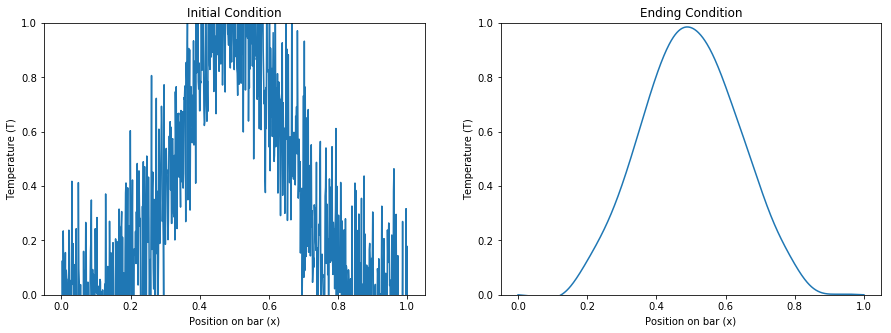

In [3]:
# create an m x n dataset from the executing the 1D diffusion solver
d = diffusion1D(nx = 800, nsteps = 2000, m = 5)
snapshots = d.run(display = True)

# de-mean data
means = snapshots.mean(axis = 0)
snapshots = snapshots - means

Using the stored distributions as input data, PCA analysis can be performed on the simulation.

In [4]:
def pca(dataset):
    covar = np.cov(dataset, rowvar = 0)
    values, vectors = np.linalg.eigh(covar)
    
    # order eigenvalue, vector lists by decreasing magnitude
    i = np.argsort(values)[::-1]
    vectors = vectors[:, i]
    values = values[i]
    return values, vectors

values, vectors = pca(snapshots)

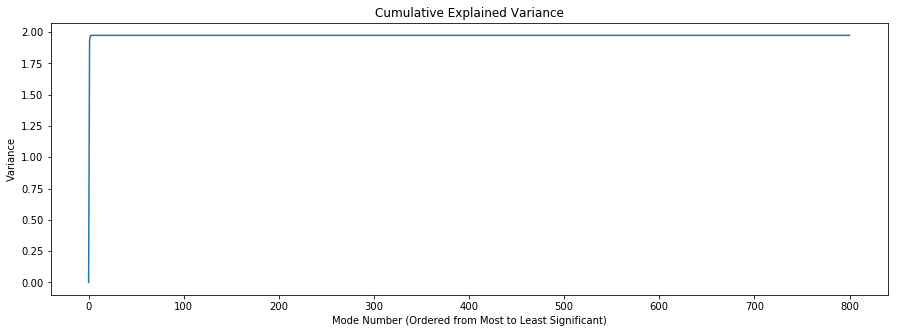

In [5]:
# plot cumulative explained variance vs. mode number
plt.plot(np.insert(np.cumsum(values), 0, 0))
plt.title('Cumulative Explained Variance')
plt.ylabel('Variance')
plt.xlabel('Mode Number (Ordered from Most to Least Significant)')

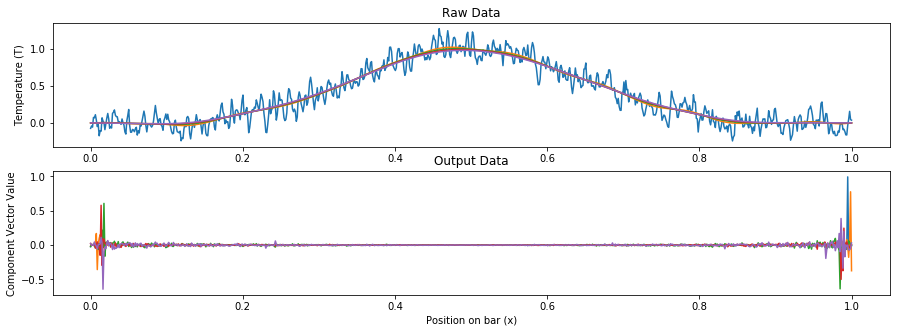

In [6]:
# compare output and raw data
fig, (ax1, ax2) = plt.subplots(2, 1)
x_values = np.linspace(0, d.L, d.nx)
for i in range(0, d.m):
    ax1.plot(x_values, snapshots[i] + means)
    ax2.plot(x_values, vectors[i])

ax1.set_title('Raw Data')
ax2.set_title('Output Data')
ax1.set_ylabel('Temperature (T)')
ax2.set_ylabel('Component Vector Value')
plt.xlabel('Position on bar (x)')

Visually inspecting the first few vector outputs (ordered according to most significant mode value) compared to the raw data, it would appear the locations of greatest variance are towards the extremes of the 1d domain; that is, the areas of most temperature difference over time occur at the edges of the bar.

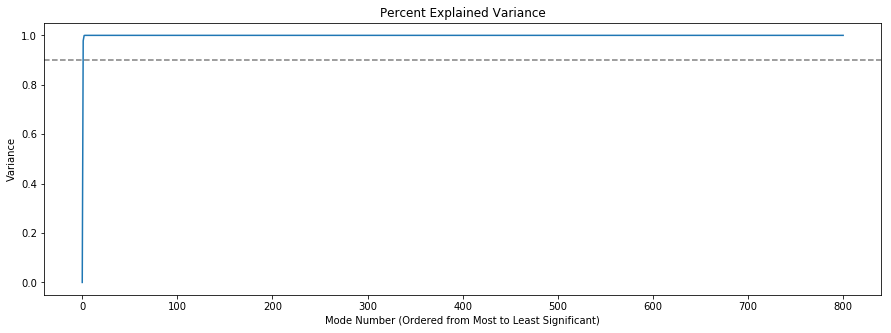

In [7]:
# plot percent explained variance vs. mode number
pct_var = values / np.sum(values)
plt.plot(np.insert(np.cumsum(pct_var), 0, 0))
plt.axhline(y = 0.9, linestyle = '--', color = 'gray')

plt.title('Percent Explained Variance')
plt.ylabel('Variance')
plt.xlabel('Mode Number (Ordered from Most to Least Significant)')

90% of the explained variance is captured by the first 1 components.


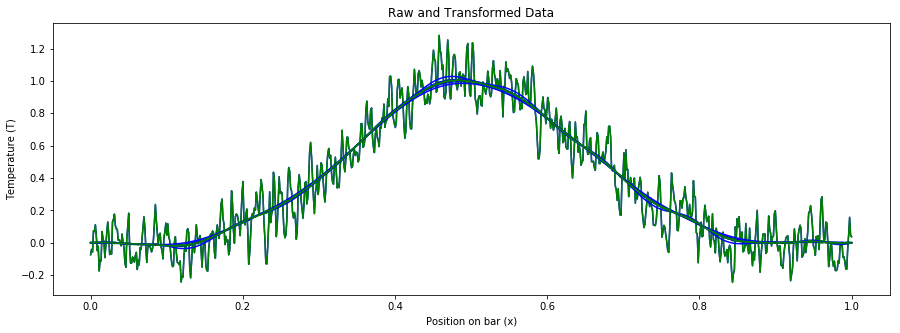

In [8]:
# perform pca transform
def pca_trans(vectors, snapshots, means, k = len(vectors)):
    vectors = vectors[:, : k + 1]
    return reduce(np.dot, [snapshots, vectors, vectors.T]) + means

# calculate 90% threshold index
k = np.argmax(np.cumsum(pct_var) > .9)
print('90%% of the explained variance is captured by the first %d components.' % (k + 1))
recon = pca_trans(vectors, snapshots, means, k)

# plot transformed snapshots
for i in range(d.m):
    plt.plot(x_values, snapshots[i] + means, color = 'b')
    plt.plot(x_values, recon[i], color = 'g')

plt.title('Raw and Transformed Data')
plt.ylabel('Temperature (T)')
plt.xlabel('Position on bar (x)')

Using a 90% threshold of explained variance, PCA does a fairly good job of reconstructing the raw data; as evidenced by the goodness of fit between the raw and reconstructed snapshots, it appears to capture the majority of data features.

The periodogram at timestep 0 has a maximum peak at 0.0350.
The periodogram at timestep 1 has a maximum peak at 0.0350.
The periodogram at timestep 2 has a maximum peak at 0.0350.
The periodogram at timestep 3 has a maximum peak at 0.0350.
The periodogram at timestep 4 has a maximum peak at 0.0025.


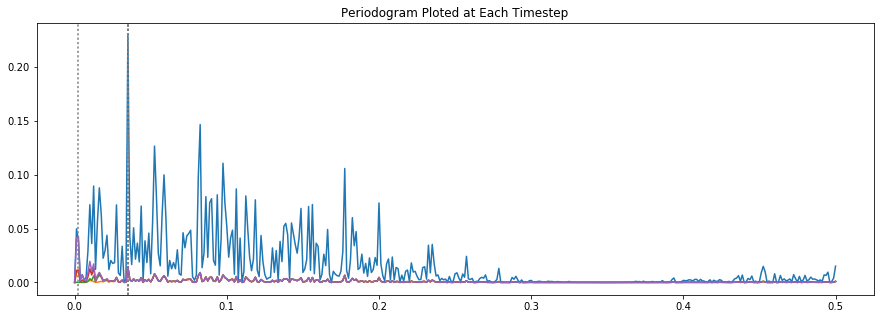

In [9]:
def plot_periodogram(f, p, i):
    max_value = f[np.argmax(p)]
    plt.plot(f, p)
    plt.axvline(max_value, ls = ':', color = 'gray')
    print('The periodogram at timestep %d has a maximum peak at %.4f.' % (i, max_value))
    
f, p = periodogram(snapshots)

for i, p_i in enumerate(p):
    plot_periodogram(f, p_i, i)
plt.title('Periodogram Ploted at Each Timestep')

The maximum peak for each snapshot fluctuats between 0.0025 and 0.0263; since samples were made 800 times along a single unit, this corresponds to a period of $\frac{1}{0.0263}\cdot\frac{1}{800}\approx 0.0476$ for the first snapshot and $\frac{1}{0.0025}\cdot\frac{1}{800}\approx 0.5$ for the last.